# Pendientes

Nada

# Gpu

In [3]:
!nvidia-smi

Mon Sep 15 18:59:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Set_Up

In [5]:
symbol = "BTCUSD"
root_data = f'/content/drive/MyDrive/Course Folder/Forex/XAUUSD/'
print(root_data)

direction = 'Short'
direction_number = -1

symbol = 'BTCUSD'
strategy = 'Kalman'
time_frame = 'M5'

trade_evolution = 'st_Max'
result_field = 'st_PnL'


/content/drive/MyDrive/Course Folder/Forex/XAUUSD/


# Libraries

In [6]:
!pip install ta-lib
import talib as ta
print(ta.__version__)

0.6.7


In [7]:
import numpy as np
import pandas as pd
import os
import joblib
import math
import time

from itertools import combinations, product

from tqdm.auto import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

from xgboost import XGBClassifier, XGBRegressor

import tensorflow as tf

import sys
sys.path.append("..")

from __future__ import annotations
from typing import Tuple, List, Optional, Dict, Any

from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, log_loss, r2_score)

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data



## Features

In [70]:
def kalman_line(source, kalman_length: int, smooth: int):
    """
    Pine → Python: devuelve SOLO la serie 'kalman_line' (EMA del núcleo Kalman).
    - source: pd.Series o array-like de floats
    - kalman_length: int (mismo rol que length_kal en Pine)
    - smooth: int (longitud de la EMA equivalente a ta.ema(..., smooth))
    """
    import numpy as np
    import pandas as pd

    src = pd.Series(source, dtype="float64")
    n = len(src)
    if n == 0:
        return src  # Serie vacía

    # Términos equivalentes al Pine
    sqrt_term   = np.sqrt((kalman_length / 10000.0) * 2.0)
    length_term = kalman_length / 10000.0

    # Estados recursivos (kf_c y velo_c)
    kf_c   = np.full(n, np.nan, dtype="float64")
    velo_c = np.full(n, np.nan, dtype="float64")

    # Inicialización (nz(kf_c[1], source) en la barra 0 ⇒ usar source[0])
    first_val = float(src.iloc[0]) if pd.notna(src.iloc[0]) else np.nan
    kf_c[0] = first_val
    velo_c[0] = 0.0

    # Recurrencia
    for i in range(1, n):
        prev_kf = kf_c[i - 1] if not np.isnan(kf_c[i - 1]) else float(src.iloc[i])
        curr_src = float(src.iloc[i]) if pd.notna(src.iloc[i]) else prev_kf
        dk_c = curr_src - prev_kf
        smooth_c = prev_kf + dk_c * sqrt_term
        prev_velo = velo_c[i - 1] if not np.isnan(velo_c[i - 1]) else 0.0
        velo_c[i] = prev_velo + length_term * dk_c
        kf_c[i] = smooth_c + velo_c[i]

    kf_series = pd.Series(kf_c, index=src.index)

    # EMA equivalente a ta.ema(kf_c, smooth)
    kal = kf_series.ewm(span=smooth, adjust=False).mean()

    # Si te pasan np.ndarray, devuelve np.ndarray; si pd.Series, devuelve Series
    return kal.to_numpy() if not isinstance(source, pd.Series) else kal


In [23]:
def slope(src: pd.Series,
          length_kal: int,
          smooth_kal: int,
          slopeLen: int,
          offset: int) -> pd.DataFrame:

    n = len(src)
    kf_state = np.full(n, np.nan)
    kf_velo  = np.zeros(n)
    sqrt_factor = np.sqrt(length_kal / 10000.0 * 2.0)
    vel_factor  = length_kal / 10000.0

    for i in range(n):
        if i == 0:
            prev_state = src.iloc[0]
            prev_velo  = 0.0
        else:
            prev_state = kf_state[i-1] if not np.isnan(kf_state[i-1]) else src.iloc[i]
            prev_velo  = kf_velo[i-1]

        dk = src.iloc[i] - prev_state
        smooth = prev_state + dk * sqrt_factor
        kf_velo[i]  = prev_velo + vel_factor * dk
        kf_state[i] = smooth + kf_velo[i]

    # 2) EMA smoothing --------------------------------------------------
    kal = pd.Series(kf_state, index=src.index).ewm(span=smooth_kal, adjust=False).mean()

    # 3) Slope/divergence -----------------------------------------------
    validLen = max(slopeLen, 1)
    slope_div = kal.diff(validLen) / validLen
    slope_signal = (slope_div > slope_div.shift(1)).astype(int)

    # 4) Angle in degrees -----------------------------------------------
    price_change = kal - kal.shift(validLen)
    slope_angle = np.degrees(np.arctan(price_change))
    slope_angle_signal = (slope_angle > slope_angle.shift(1)).astype(int)

    # 5) Linear regression prediction ----------------------------------
    def _linreg(y):
        x = np.arange(len(y))
        m, b = np.polyfit(x, y, 1)
        return b + m * (len(y)-1)

    slope_lin_reg = kal.rolling(window=slopeLen).apply(_linreg, raw=False)
    slope_lin_reg = slope_lin_reg.shift(-offset)  # apply Pine-style offset
    slope_lin_reg_signal = (slope_lin_reg > slope_lin_reg.shift(1)).astype(int)

    # 6) Pack results ---------------------------------------------------
    return pd.DataFrame({
        'slope_div':            slope_div,
        'slope_signal':         slope_signal,
        'slope_angle':          slope_angle,
        'slope_angle_signal':   slope_angle_signal,
        'slope_lin_reg':        slope_lin_reg,
        'slope_lin_reg_signal': slope_lin_reg_signal
    })

In [24]:
def get_parkinson(price_data, window=10, trading_periods=50, clean=True):
    rs = (1.0 / (4.0 * math.log(2.0))) * ((price_data['High'] / price_data['Low']).apply(np.log))**2.0

    def f(v):
        return (trading_periods * v.mean())**0.5

    result = rs.rolling(
        window=window,
        center=False
    ).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

In [25]:
def get_HodgesTompkins(price_data, window=30, trading_periods=50, clean=True):

    log_return = (price_data['Close'] / price_data['Close'].shift(1)).apply(np.log)

    vol = log_return.rolling(
        window=window,
        center=False
    ).std() * math.sqrt(trading_periods)

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h**2 - 1) / (3 * n**2)))

    result = vol * adj_factor

    if clean:
        return result.dropna()
    else:
        return result

In [26]:
def get_skew(price_data, window=30, clean=True):

    log_return = (price_data['Close'] / price_data['Close'].shift(1)).apply(np.log)

    result = log_return.rolling(
        window=window,
        center=False
    ).skew()

    if clean:
        return result.dropna()
    else:
        return

In [27]:
def get_kurtosis(price_data, window=30, clean=True):

    log_return = (price_data['Close'] / price_data['Close'].shift(1)).apply(np.log)

    result = log_return.rolling(
        window=window,
        center=False
    ).kurt()

    if clean:
        return result.dropna()
    else:
        return result

In [28]:
def get_YangZhang(price_data, window=30, trading_periods=50, clean=True):

    log_ho = (price_data['High'] / price_data['Open']).apply(np.log)
    log_lo = (price_data['Low'] / price_data['Open']).apply(np.log)
    log_co = (price_data['Close'] / price_data['Open']).apply(np.log)

    log_oc = (price_data['Open'] / price_data['Close'].shift(1)).apply(np.log)
    log_oc_sq = log_oc**2

    log_cc = (price_data['Close'] / price_data['Close'].shift(1)).apply(np.log)
    log_cc_sq = log_cc**2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))
    open_vol = log_oc_sq.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))
    window_rs = rs.rolling(
        window=window,
        center=False
    ).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(np.sqrt) * math.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

In [29]:
def get_RogersSatchell(price_data, window=30, trading_periods=50, clean=True):

    log_ho = (price_data['High']  / price_data['Open']).apply(np.log)
    log_lo = (price_data['Low']   / price_data['Open']).apply(np.log)
    log_co = (price_data['Close'] / price_data['Open']).apply(np.log)

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean())**0.5

    result = rs.rolling(
        window=window,
        center=False
    ).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

In [30]:
def get_GermanKlass(price_data, window=22, trading_periods=50, clean=True):

    log_hl = (price_data['High'] / price_data['Low']).apply(np.log)
    log_co = (price_data['Close'] / price_data['Open']).apply(np.log)

    rs = 0.5 * log_hl**2 - (2*math.log(2)-1) * log_co**2

    def f(v):
        return (trading_periods * v.mean())**0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

In [67]:
def create_features(stock_data: pd.DataFrame) -> pd.DataFrame:

    periods        = [3, 7, 14]
    ema_periods    = [10, 21, 50, 100, 200]
    kalman_periods = [300, 600, 900]
    slope_length   = [3, 6, 9]

    features = pd.DataFrame(index=stock_data.index)

    # ───────────────────────── Indicadores por período ─────────────────────────
    t0 = time.time()
    indicator_columns = {'RSI': [], 'MFI': [], 'OBV': []}

    for period in tqdm(periods, desc="Indicators (RSI/MFI/OBV)"):
        rsi_col = f'RSI_{period}'
        features[rsi_col] = ta.RSI(stock_data['Close'], timeperiod=period)
        indicator_columns['RSI'].append(rsi_col)

        mfi_col = f'MFI_{period}'
        features[mfi_col] = ta.MFI(
            stock_data['High'], stock_data['Low'], stock_data['Close'],
            stock_data['Volume'], timeperiod=period
        )
        indicator_columns['MFI'].append(mfi_col)

        obv_col = f'OBV_{period}'
        features[obv_col] = ta.OBV(stock_data['Close'], stock_data['Volume'])
        indicator_columns['OBV'].append(obv_col)

    # diffs y combinaciones dentro de cada familia
    for indicator, cols in indicator_columns.items():
        for col in tqdm(cols, desc=f"{indicator}: diffs", leave=False):
            features[f'{col}_diff'] = features[col].diff()
        pairs = list(combinations(cols, 2))
        for col1, col2 in tqdm(pairs, desc=f"{indicator}: pairwise", leave=False):
            features[f'{col1} - {col2}'] = features[col1] - features[col2]
    tqdm.write(f"[Timing] Indicators block: {time.time()-t0:.2f}s")

    # ───────────────────────── Cruces SMA / EMA ─────────────────────────
    t0 = time.time()
    sma_ema_pairs = list(product(ema_periods, ema_periods)) # Modified to use ema_periods
    for short_p, long_p in tqdm(sma_ema_pairs, desc="SMA/EMA Crossovers"):
        features[f'SMA_Crossover_{short_p}_{long_p}'] = (
            ta.SMA(stock_data['Close'], timeperiod=short_p)
            - ta.SMA(stock_data['Close'], timeperiod=long_p)
        )
        features[f'EMA_Crossover_{short_p}_{long_p}'] = (
            ta.EMA(stock_data['Close'], timeperiod=short_p)
            - ta.EMA(stock_data['Close'], timeperiod=long_p)
        )
    tqdm.write(f"[Timing] SMA/EMA block: {time.time()-t0:.2f}s")

    # ───────────────────────── Kalman y derivados ───────────────────────
    t0 = time.time()
    kal_cols = []
    for period in tqdm(kalman_periods, desc="Kalman & Derivatives"):
        kal = pd.Series(
            kalman_line(stock_data['Close'], kalman_length=period, smooth=3),
            index=stock_data.index
        )
        kname = f'Kal_{period}'
        kal_cols.append(kname)

        features[kname]                           = kal
        features[f'Close_Kal_{period}']           = stock_data['Close'] - kal
        features[f'Kal_change_{period}']          = kal.diff(1)              # t - (t-1)
        features[f'Kal_prev_minus_now_{period}']  = kal.shift(1) - kal       # (t-1) - t
        features[f'Kal_prev2_minus_now_{period}'] = kal.shift(2) - kal       # (t-2) - t
        features[f'Kal_change2_{period}']         = kal.diff(2)              # t - (t-2)

    # diferencias entre Kalman de distintos periodos
    kal_pairs = list(combinations(kal_cols, 2))
    for c1, c2 in tqdm(kal_pairs, desc="Kalman pairwise"):
        features[f'{c1}_minus_{c2}'] = features[c1] - features[c2]
    tqdm.write(f"[Timing] Kalman block: {time.time()-t0:.2f}s")

    # ───────────────────────── Slopes ───────────────────────────────────
    t0 = time.time()
    slope_indicator_columns = {
        'slope_div': [],
        'slope_signal': [],
        'slope_angle': [],
        'slope_angle_signal': [],
        'slope_lin_reg': [],
        'slope_lin_reg_signal': []
    }

    slope_jobs = list(product(kalman_periods, slope_length))
    for period, sLen in tqdm(slope_jobs, desc="Slopes (kal_len × slope_len)"):
        df_s = slope(stock_data['Close'], length_kal=period, smooth_kal=3,
                     slopeLen=sLen, offset=-1)

        column_mapping = {
            'slope_div':            f'slope_div_{period}_{sLen}',
            'slope_signal':         f'slope_signal_{period}_{sLen}',
            'slope_angle':          f'slope_angle_{period}_{sLen}',
            'slope_angle_signal':   f'slope_angle_signal_{period}_{sLen}',
            'slope_lin_reg':        f'slope_lin_reg_{period}_{sLen}',
            'slope_lin_reg_signal': f'slope_lin_reg_signal_{period}_{sLen}'
        }

        for indicator, col_name in column_mapping.items():
            series = df_s[indicator]
            features[col_name] = series
            features[f'{col_name}_diff'] = series.diff()
            slope_indicator_columns[indicator].append(col_name)

    # pairwise entre slopes por tipo de indicador
    for indicator, cols in slope_indicator_columns.items():
        pairs = list(combinations(cols, 2))
        for c1, c2 in tqdm(pairs, desc=f"{indicator}: pairwise", leave=False):
            features[f'{c1} - {c2}'] = features[c1] - features[c2]
    tqdm.write(f"[Timing] Slopes block: {time.time()-t0:.2f}s")


    return features

## 1_min

In [68]:
# Read the CSV file
df_1min = pd.read_csv(root_data + 'Data/'+symbol+'_M1.csv', index_col=0)
df_1min.index = pd.to_datetime(df_1min.index)
#df_1min = df_1min.iloc[-500000:,]
df_1min = df_1min.iloc[-5000:,]

print('Min_Date : ', df_1min.index.min())
print('Min_Date : ', df_1min.index.max())
print('Number_Rows = ',len(df_1min.index))
print('\n')

df_1min.tail()

Min_Date :  2025-07-23 11:00:00
Min_Date :  2025-07-26 23:58:00
Number_Rows =  5000




,Open,High,Low,Close,Volume,Spread
Date,,,,,,
2025-07-26 23:54:00,117987.25,118052.38,117986.50,118005.75,114,725
2025-07-26 23:55:00,118008.75,118038.38,118008.50,118031.88,126,1200
2025-07-26 23:56:00,118032.13,118032.88,118012.00,118013.88,63,587
2025-07-26 23:57:00,118014.13,118049.38,118014.13,118045.63,131,1200
2025-07-26 23:58:00,118045.38,118047.63,118041.13,118042.63,165,1200


**Features**

In [69]:
features = create_features(df_1min)

print("Number of features are:", features.shape[1])
print(features.shape)
features.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M1_Raw_Features.csv')
features.tail(5)

Indicators (RSI/MFI/OBV):   0%|          | 0/3 [00:00<?, ?it/s]

RSI: diffs:   0%|          | 0/3 [00:00<?, ?it/s]

RSI: pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

MFI: diffs:   0%|          | 0/3 [00:00<?, ?it/s]

MFI: pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

OBV: diffs:   0%|          | 0/3 [00:00<?, ?it/s]

OBV: pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

[Timing] Indicators block: 0.09s


SMA/EMA Crossovers:   0%|          | 0/25 [00:00<?, ?it/s]

[Timing] SMA/EMA block: 0.05s


Kalman & Derivatives:   0%|          | 0/3 [00:00<?, ?it/s]

Kalman pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

[Timing] Kalman block: 0.13s


Slopes (kal_len × slope_len):   0%|          | 0/9 [00:00<?, ?it/s]

slope_div: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_angle: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_angle_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_lin_reg: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_lin_reg_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

[Timing] Slopes block: 8.40s
Number of features are: 422
(5000, 422)


,RSI_3,MFI_3,OBV_3,RSI_7,MFI_7,OBV_7,RSI_14,MFI_14,OBV_14,RSI_3_diff,...,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9,slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3,slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6,slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9,slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6,slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9,slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-26 23:54:00,59.503449,77.093914,3158.0,47.305708,26.347289,3158.0,45.534274,41.494018,3158.0,30.539878,...,0,0,0,0,0,0,0,0,0,0
2025-07-26 23:55:00,78.807008,100.000000,3284.0,57.553352,42.089605,3284.0,50.739877,49.204942,3284.0,19.303559,...,0,0,0,0,0,0,0,0,0,0
2025-07-26 23:56:00,52.800512,79.208097,3221.0,49.774008,50.955271,3221.0,47.380454,43.995750,3221.0,-26.006496,...,0,-1,-1,0,-1,-1,0,0,1,1
2025-07-26 23:57:00,74.801824,80.314085,3352.0,60.704371,67.024969,3352.0,53.258991,45.709349,3352.0,22.001312,...,1,0,0,1,-1,-1,0,0,1,1
2025-07-26 23:58:00,70.166202,82.453819,3187.0,59.282191,83.047890,3187.0,52.660348,52.658620,3187.0,-4.635622,...,0,0,0,0,0,0,0,0,0,0


In [49]:
#for col in features.columns:
 # print(col)

In [50]:
features = pd.read_csv(root_data+'Results/'+symbol+'_M1_Raw_Features.csv')
features["Date"] = pd.to_datetime(features["Date"])
print(features.shape)
features.head(5)

(499477, 430)


,Date,RSI_3,MFI_3,ADX_3,OBV_3,AD_3,ROCP_3,RSI_5,MFI_5,ADX_5,...,slope_angle_1000_18,slope_angle_signal_1000_18,slope_lin_reg_1000_18,slope_lin_reg_signal_1000_18,slope_div_1000_21,slope_signal_1000_21,slope_angle_1000_21,slope_angle_signal_1000_21,slope_lin_reg_1000_21,slope_lin_reg_signal_1000_21
0,2024-08-10 03:13:00,78.532894,100.000000,59.997082,4467.0,1675.708364,0.001347,70.672745,83.617899,37.432373,...,87.707913,0,60745.035016,0,7.047342,1,89.612857,1,60781.106588,0
1,2024-08-10 03:14:00,86.038845,100.000000,66.538697,4590.0,1772.390471,0.000574,76.454951,100.000000,42.265978,...,84.642099,0,60754.046273,1,7.198222,1,89.620972,1,60780.131706,0
2,2024-08-10 03:15:00,91.979547,100.000000,74.243521,4819.0,1958.046445,0.001496,82.534055,100.000000,48.408153,...,86.328547,1,60774.157942,1,6.640297,0,89.589126,0,60785.524051,1
3,2024-08-10 03:16:00,68.696313,100.000000,80.896789,4523.0,1730.885075,0.000904,70.459011,100.000000,54.848595,...,87.937850,1,60805.299029,1,5.592227,0,89.512126,0,60800.228357,1
4,2024-08-10 03:17:00,71.355207,68.449094,82.347722,4765.0,1647.528274,0.000460,71.723188,77.607318,59.089957,...,88.753833,1,60842.297304,1,4.103293,0,89.335108,0,60821.681985,1


**Scale_features**

In [51]:
cols_to_scale = features.columns[1:]
cols_to_scale

Index(['RSI_3', 'MFI_3', 'ADX_3', 'OBV_3', 'AD_3', 'ROCP_3', 'RSI_5', 'MFI_5',
       'ADX_5', 'OBV_5',
       ...
       'slope_angle_1000_18', 'slope_angle_signal_1000_18',
       'slope_lin_reg_1000_18', 'slope_lin_reg_signal_1000_18',
       'slope_div_1000_21', 'slope_signal_1000_21', 'slope_angle_1000_21',
       'slope_angle_signal_1000_21', 'slope_lin_reg_1000_21',
       'slope_lin_reg_signal_1000_21'],
      dtype='object', length=429)

In [52]:
### Scale Features with Rolling Window
window = 200
rolling = features[cols_to_scale].rolling(window)
features[cols_to_scale] = (features[cols_to_scale] - rolling.mean()) / rolling.std()

print("DataFrame with rolling-scaled features:")
print(features.shape)
features.head()


DataFrame with rolling-scaled features:
(499477, 430)


,Date,RSI_3,MFI_3,ADX_3,OBV_3,AD_3,ROCP_3,RSI_5,MFI_5,ADX_5,...,slope_angle_1000_18,slope_angle_signal_1000_18,slope_lin_reg_1000_18,slope_lin_reg_signal_1000_18,slope_div_1000_21,slope_signal_1000_21,slope_angle_1000_21,slope_angle_signal_1000_21,slope_lin_reg_1000_21,slope_lin_reg_signal_1000_21
0,2024-08-10 03:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-08-10 03:14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-08-10 03:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-08-10 03:16:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-08-10 03:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
features.to_csv(root_data+'Results/'+symbol+'_M1_Scale_Features.csv')

**Plots**

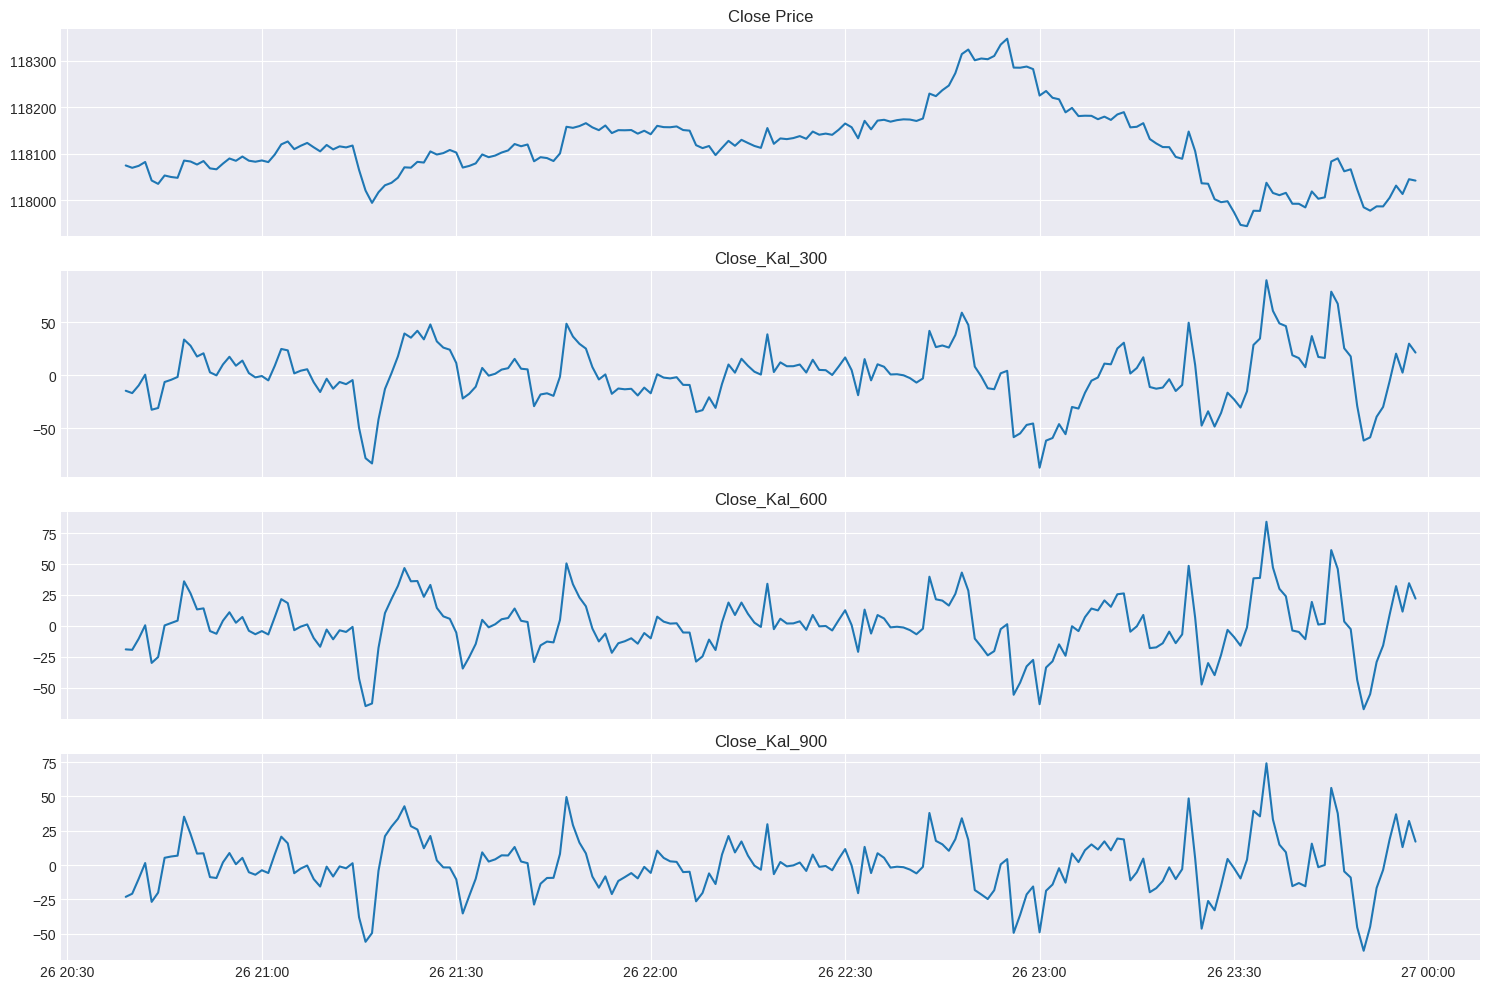

In [65]:
import matplotlib.pyplot as plt

last_500_features = features.tail(200)
last_500_df = df_1min.tail(200)

indicators_to_plot = ['Close','Close_Kal_300','slope_angle_1000_18']

indicator_columns = [col for col in last_500_features.columns if any(ind in col for ind in indicators_to_plot)]

# Plotting
fig, axes = plt.subplots(nrows=len(indicator_columns) + 1, ncols=1, figsize=(15, 2.5 * (len(indicator_columns) + 1)), sharex=True) # Reduced height

# Plot Close price
axes[0].plot(last_500_df.index, last_500_df['Close'])
axes[0].set_title('Close Price')
axes[0].grid(True)

# Plot each indicator
for i, col in enumerate(indicator_columns):
    axes[i+1].plot(last_500_features.index, last_500_features[col])
    axes[i+1].set_title(col)
    axes[i+1].grid(True)

plt.tight_layout()
plt.show()

## 5_min

In [32]:
# Read the CSV file
df_5min = pd.read_csv(root_data + 'Data/'+symbol+'_M5.csv', index_col=0)
df_5min.index = pd.to_datetime(df_5min.index)
df_5min = df_5min.iloc[-1000000:,]

print('Min_Date : ', df_5min.index.min())
print('Min_Date : ', df_5min.index.max())
print('Number_Rows = ',len(df_5min.index))
print('\n')

df_5min.tail()

Min_Date :  2023-01-01 00:05:00
Min_Date :  2025-07-26 23:55:00
Number_Rows =  267395




,Open,High,Low,Close,Volume,Spread
Date,,,,,,
2025-07-26 23:35:00,117978.63,118045.75,117977.63,117993.00,679,362
2025-07-26 23:40:00,117992.38,118045.38,117980.63,118006.75,518,275
2025-07-26 23:45:00,118007.00,118100.13,117967.50,118023.88,757,100
2025-07-26 23:50:00,118023.63,118052.38,117951.88,118005.75,547,0
2025-07-26 23:55:00,118008.75,118049.38,118008.50,118042.63,485,587


**Features**

In [ ]:
start_time = time.time()

features = create_features(df_5min)
features = features.dropna()

end_time = time.time()
execution_time = end_time - start_time

print("Number of features are:", features.shape[1])
print(features.shape)
features.to_csv(root_data+'Results/'+symbol+'_M5_Raw_Features.csv')
print(f"Execution time: {execution_time:.2f} seconds")
features.tail(5)

In [ ]:
for col in features.columns:
  print(col)

In [35]:
features = pd.read_csv(root_data+'Results/'+symbol+'_M5_Raw_Features.csv')
features["Date"] = pd.to_datetime(features["Date"])
print(features.shape)
features.head(5)

(267196, 423)


,Date,RSI_3,MFI_3,OBV_3,RSI_7,MFI_7,OBV_7,RSI_14,MFI_14,OBV_14,...,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6,slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9,slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3,slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6,slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9,slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6,slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9,slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9
0,2023-01-01 16:40:00,22.481456,38.613612,1218.0,40.474306,73.864764,1218.0,46.521776,64.951583,1218.0,...,0,0,0,0,0,0,0,0,0,0
1,2023-01-01 16:45:00,41.772173,70.468434,1533.0,47.299681,81.330746,1533.0,49.596705,84.495237,1533.0,...,0,1,1,0,1,1,0,0,-1,-1
2,2023-01-01 16:50:00,41.966458,81.274463,1639.0,47.362833,83.228319,1639.0,49.624681,83.193065,1639.0,...,-1,0,0,0,1,1,1,0,0,0
3,2023-01-01 16:55:00,15.605744,84.711499,1563.0,32.179357,72.416769,1563.0,41.294133,74.454552,1563.0,...,0,0,0,0,0,0,0,0,0,0
4,2023-01-01 17:00:00,32.173994,50.483676,1591.0,38.174282,68.111476,1591.0,43.922485,76.893515,1591.0,...,0,0,0,0,0,0,0,0,0,0


**Scale_features**

In [36]:
cols_to_scale = features.columns[1:]
cols_to_scale

Index(['RSI_3', 'MFI_3', 'OBV_3', 'RSI_7', 'MFI_7', 'OBV_7', 'RSI_14',
       'MFI_14', 'OBV_14', 'RSI_3_diff',
       ...
       'slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9',
       'slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3',
       'slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6',
       'slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9',
       'slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3',
       'slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6',
       'slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9',
       'slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6',
       'slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9',
       'slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9'],
      dtype='object', length=422)

In [37]:
### Scale Features with Rolling Window
start_time = time.time()

window = 200
rolling = features[cols_to_scale].rolling(window)
features[cols_to_scale] = (features[cols_to_scale] - rolling.mean()) / rolling.std()

print("DataFrame with rolling-scaled features:")
print(features.shape)
features.head()
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


DataFrame with rolling-scaled features:
(267196, 423)
Execution time: 9.01 seconds


In [38]:
features.to_csv(root_data+'Results/'+symbol+'_M5_Scale_Features.csv')

## 10_min

In [39]:
# Read the CSV file
df_10min = pd.read_csv(root_data + 'Data/'+symbol+'_M10.csv', index_col=0)
df_10min.index = pd.to_datetime(df_10min.index)
df_10min = df_10min.iloc[-100000:,]

print('Min_Date : ', df_10min.index.min())
print('Min_Date : ', df_10min.index.max())
print('Number_Rows = ',len(df_10min.index))
print('\n')

df_10min.tail()

Min_Date :  2023-08-28 07:20:00
Min_Date :  2025-07-27 00:00:00
Number_Rows =  100000




,Open,High,Low,Close,Volume,Spread
Date,,,,,,
2025-07-26 23:20:00,118118.63,118152.00,117967.75,117998.38,910,0
2025-07-26 23:30:00,118003.13,118045.75,117921.00,117993.00,1350,362
2025-07-26 23:40:00,117992.38,118100.13,117967.50,118023.88,1275,100
2025-07-26 23:50:00,118023.63,118052.38,117951.88,118042.63,1032,0
2025-07-27 00:00:00,117987.50,118067.13,117975.00,118051.63,433,1050


**Features**

In [40]:
### Create the Features Set
features_10min = create_features(df_10min)
features_10min = features_10min.dropna()

# Add "10min_" prefix to all column names except 'Date'
features_10min = features_10min.add_prefix('10min_')
features_10min.rename(columns={'10min_Date': 'Date'}, inplace=True)

print("Number of features are:", features.shape[1])
print(features_10min.shape)
features_10min.to_csv(root_data+'Results/'+symbol+'_M10_Raw_Features.csv')
features_10min.tail(5)

Indicators (RSI/MFI/OBV):   0%|          | 0/3 [00:00<?, ?it/s]

RSI: diffs:   0%|          | 0/3 [00:00<?, ?it/s]

RSI: pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

MFI: diffs:   0%|          | 0/3 [00:00<?, ?it/s]

MFI: pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

OBV: diffs:   0%|          | 0/3 [00:00<?, ?it/s]

OBV: pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

[Timing] Indicators block: 0.10s


SMA/EMA Crossovers:   0%|          | 0/25 [00:00<?, ?it/s]

[Timing] SMA/EMA block: 0.11s


Kalman & Derivatives:   0%|          | 0/3 [00:00<?, ?it/s]

Kalman pairwise:   0%|          | 0/3 [00:00<?, ?it/s]

[Timing] Kalman block: 2.22s


Slopes (kal_len × slope_len):   0%|          | 0/9 [00:00<?, ?it/s]

slope_div: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_angle: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_angle_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_lin_reg: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

slope_lin_reg_signal: pairwise:   0%|          | 0/36 [00:00<?, ?it/s]

[Timing] Slopes block: 156.05s
Number of features are: 423
(99801, 422)


,10min_RSI_3,10min_MFI_3,10min_OBV_3,10min_RSI_7,10min_MFI_7,10min_OBV_7,10min_RSI_14,10min_MFI_14,10min_OBV_14,10min_RSI_3_diff,...,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-26 23:20:00,14.484819,-8.045692e-13,-845456.0,31.553670,64.054053,-845456.0,41.542614,58.926625,-845456.0,-12.113336,...,0,1,0,0,1,0,0,-1,-1,0
2025-07-26 23:30:00,14.040916,-7.119918e-13,-846806.0,31.122203,49.739390,-846806.0,41.248875,58.407434,-846806.0,-0.443903,...,0,0,0,0,0,0,0,0,0,0
2025-07-26 23:40:00,31.986467,3.607232e+01,-845531.0,36.900079,51.023547,-845531.0,43.709161,59.523328,-845531.0,17.945551,...,0,0,0,0,0,0,0,0,0,0
2025-07-26 23:50:00,42.852636,3.487067e+01,-844499.0,40.439391,34.923413,-844499.0,45.209480,52.838341,-844499.0,10.866169,...,0,0,0,0,0,0,0,0,0,0
2025-07-27 00:00:00,48.748168,6.233876e+01,-844066.0,42.253259,25.045209,-844066.0,45.954100,50.914197,-844066.0,5.895532,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for col in features_10min.columns:
  print(col)

In [43]:
features_10min = pd.read_csv(root_data+'Results/'+symbol+'_M10_Raw_Features.csv')
features_10min["Date"] = pd.to_datetime(features_10min["Date"])
print(features_10min.shape)
features_10min.head(5)

(99801, 423)


,Date,10min_RSI_3,10min_MFI_3,10min_OBV_3,10min_RSI_7,10min_MFI_7,10min_OBV_7,10min_RSI_14,10min_MFI_14,10min_OBV_14,...,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9
0,2023-08-29 16:30:00,73.246671,36.852238,3094.0,65.767629,75.538869,3094.0,59.630253,60.070984,3094.0,...,0,0,0,0,0,0,0,0,0,0
1,2023-08-29 16:40:00,86.710454,76.558497,4861.0,74.689442,78.756598,4861.0,65.568671,68.210709,4861.0,...,0,0,0,0,0,0,0,0,0,0
2,2023-08-29 16:50:00,56.043433,59.552132,3118.0,61.200338,56.448358,3118.0,58.814805,62.361272,3118.0,...,0,0,0,0,0,0,0,0,0,0
3,2023-08-29 17:00:00,88.354147,68.795977,5185.0,81.540947,63.038461,5185.0,73.935551,71.083513,5185.0,...,0,0,0,0,0,0,0,0,0,0
4,2023-08-29 17:10:00,90.046597,69.307403,7036.0,83.131973,67.638591,7036.0,75.433478,73.272780,7036.0,...,0,0,0,0,0,0,0,0,0,0


**Scale_features**

In [44]:
cols_to_scale = features_10min.columns[1:]
cols_to_scale

Index(['10min_RSI_3', '10min_MFI_3', '10min_OBV_3', '10min_RSI_7',
       '10min_MFI_7', '10min_OBV_7', '10min_RSI_14', '10min_MFI_14',
       '10min_OBV_14', '10min_RSI_3_diff',
       ...
       '10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9',
       '10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3',
       '10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6',
       '10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9',
       '10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3',
       '10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6',
       '10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9',
       '10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6',
       '10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9',
       '10min_slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9'],
      dtype='object', length=422)

In [45]:
### Scale Features with Rolling Window
window = 200
rolling = features_10min[cols_to_scale].rolling(window)
features_10min[cols_to_scale] = (features_10min[cols_to_scale] - rolling.mean()) / rolling.std()

print("DataFrame with rolling-scaled features:")
print(features_10min.shape)
features_10min.tail()


DataFrame with rolling-scaled features:
(99801, 423)


,Date,10min_RSI_3,10min_MFI_3,10min_OBV_3,10min_RSI_7,10min_MFI_7,10min_OBV_7,10min_RSI_14,10min_MFI_14,10min_OBV_14,...,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_600_9,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_6 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_3,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_600_9 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_6,10min_slope_lin_reg_signal_900_3 - slope_lin_reg_signal_900_9,10min_slope_lin_reg_signal_900_6 - slope_lin_reg_signal_900_9
99796,2025-07-26 23:20:00,-1.843418,-1.791219,1.143835,-1.850145,0.422298,1.143835,-1.777513,0.242242,1.143835,...,-0.017109,2.835738,-0.07562,-0.040757,2.311907,-0.038032,-0.018215,-3.328181,-2.573518,0.031559
99797,2025-07-26 23:30:00,-1.837793,-1.770482,1.009541,-1.855928,-0.297521,1.009541,-1.787742,0.204602,1.009541,...,-0.017109,0.014108,-0.07562,-0.040757,0.022890,-0.038032,-0.018215,-0.081175,-0.038032,0.031559
99798,2025-07-26 23:40:00,-1.020618,-0.589974,1.117434,-1.411074,-0.223900,1.117434,-1.477693,0.291035,1.117434,...,-0.017109,0.014108,-0.07562,-0.040757,0.022890,-0.038032,-0.018215,-0.081175,-0.038032,0.031559
99799,2025-07-26 23:50:00,-0.526559,-0.623546,1.200365,-1.137135,-1.044233,1.200365,-1.286629,-0.215838,1.200365,...,-0.017109,0.014108,-0.07562,-0.040757,0.022890,-0.038032,-0.018215,-0.081175,-0.038032,0.031559
99800,2025-07-27 00:00:00,-0.254282,0.274725,1.228747,-0.993295,-1.540846,1.228747,-1.186525,-0.356296,1.228747,...,-0.017109,0.014108,-0.07562,-0.040757,0.022890,-0.038032,-0.018215,-0.081175,-0.038032,0.031559


In [46]:
features_10min.to_csv(root_data+'Results/'+symbol+'_M10_Scale_Features.csv')

# Feature Importance

## Labels

In [ ]:
lab = pd.read_csv(root_data + 'Results/'+symbol+'_'+strategy+'_'+time_frame+'_Strategy_Gen_Labels.csv', index_col=0)
lab['Date'] = pd.to_datetime(lab['Date'])

print('Min_Date    : ',lab['Date'].min())
print('Min_Date    : ',lab['Date'].max(),'\n')
print('Number_Rows : ',lab.shape,'\n')
print('Columns     : ',lab.columns)

lab['Open_Trade'].value_counts()

In [ ]:
#analyse_column = 'st_atr_max_PnL'
analyse_column = 'st_Max'

st_max_0  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),:]['Open_Trade'].count()
st_max_1  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),analyse_column].mean()
st_max_2  = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] >= 1.93),analyse_column].sum()
st_max_25 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 1.93),analyse_column].sum()


st_max_3 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 0)),analyse_column].sum()

st_max_4 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 0.7) & (lab['st_atr_max_PnL'] <= 1)),analyse_column].sum()

st_max_5 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 1) &
                   (lab['st_atr_max_PnL'] <= 1.5)),analyse_column].sum()

st_max_6 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 1.5) &
                   (lab['st_atr_max_PnL'] <= 2)),analyse_column].sum()

st_max_7 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] > 2)),analyse_column].sum()


print(f'Total_Trades = {st_max_0:,.0f}\n')
print(f'Mean st_atr_max_PnL = {st_max_1:,.2f}\n')
print(f'Above_Mean = {st_max_2:,.2f}')
print(f'Below_Mean = {st_max_25:,.2f}\n')

print(f'<= 0.5 = {st_max_3:,.2f}')
print(f'> 0.5 & <= 1 = {st_max_4:,.2f}')
print(f'> 1 & <= 1.5 = {st_max_5:,.2f}')
print(f'> 1.5 & <= 2 = {st_max_6:,.2f}')
print(f'> 2 = {st_max_7:,.2f}')

In [ ]:
analyse_column = 'st_atr_max_PnL'

st_max_0 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),:]['Open_Trade'].count()
st_max_1 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)),analyse_column].mean()
st_max_2 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] >= 1.93),analyse_column].count()
st_max_25 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) & (lab['st_atr_max_PnL'] <= 1.93),analyse_column].count()

st_max_3 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                    (lab['st_atr_max_PnL'] <= 0.5)),analyse_column].count()

st_max_4 = lab.loc[(((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                     (lab['st_atr_max_PnL'] >= 0.5) & (lab['st_atr_max_PnL'] <= 1)),analyse_column].count()

st_max_5 = lab.loc[((lab['Open_Trade']==1) |(lab['Open_Trade']==-1)) &
                   (lab['st_atr_max_PnL'] >= 1), analyse_column].count()

print(f'Total_Trades = {st_max_0:,.0f}\n')
print(f'Mean st_atr_max_PnL = {st_max_1:,.2f}\n')
print(f'Above_Mean = {st_max_2:,.2f}')
print(f'Below_Mean = {st_max_25:,.2f}\n')

print(f'<= 0.5 = {st_max_3:,.2f}')
print(f'> 0.5 & <= 1 = {st_max_4:,.2f}')
print(f'> 1 = {st_max_5:,.2f}')


In [ ]:
# --- Parámetros / campos
result_field = 'st_atr_max_PnL'

valid = (
    (lab['Type'] == direction) &
    (lab['Open_Trade'].isin([1, -1])) &
    (lab[result_field].notna())
)

# --- Conteos por rango (st_max_4..6)
st_max_4 = (valid & (lab[result_field] <= 0.5)).sum()
st_max_5 = (valid & (lab[result_field] >= 0.5) & (lab[result_field] <= 1.0)).sum()
st_max_6 = (valid & (lab[result_field] > 1.0)).sum()

print(f'<= 0.5          = {st_max_4:,d}')
print(f'> 0.5 & <= 1.0  = {st_max_5:,d}')
print(f'> 1.0           = {st_max_6:,d}')

# --- Etiquetado en la columna "label" con valores 4/5/6
lab['label'] = np.nan
#lab.loc[valid & (lab[result_field] <= 0.5), 'label'] = 0
#lab.loc[valid & (lab[result_field] > 0.5) & (lab[result_field] <= 1.0), 'label'] = 1
#lab.loc[valid & (lab[result_field] > 1.0), 'label'] = 2

lab['label'] = np.nan
lab.loc[valid & (lab[result_field] <= 1), 'label'] = 0
lab.loc[valid & (lab[result_field] >= 1), 'label'] = 1


# --- Mantener solo filas válidas y con label
lab = lab.loc[valid & lab['label'].notna()].copy()
lab['label'] = lab['label'].astype('int8')

# --- Ver distribución de labels 4/5/6
print('\nValue counts de label 4/5/6:')
print(lab['label'].value_counts(dropna=False).sort_index())


## Features

In [ ]:
raw_feat_1min = pd.read_csv(root_data+'Results/'+symbol+'_M1_Raw_Features.csv')
raw_feat_1min["Date"] = pd.to_datetime(raw_feat_1min["Date"])
print(raw_feat_1min.shape)
#raw_feat_1min.head(5)

In [ ]:
scale_feat_1min = pd.read_csv(root_data+'Results/'+symbol+'_M1_Scale_Features.csv')
scale_feat_1min = scale_feat_1min.drop('Unnamed: 0', axis=1)
scale_feat_1min["Date"] = pd.to_datetime(scale_feat_1min["Date"])
print(scale_feat_1min.shape)
#scale_feat_5min.head(5)

In [ ]:
raw_feat_5min = pd.read_csv(root_data+'Results/'+symbol+'_M5_Raw_Features.csv')
raw_feat_5min["Date"] = pd.to_datetime(raw_feat_5min["Date"])
print(raw_feat_5min.shape)
#raw_feat_5min.head(5)

In [ ]:
scale_feat_5min = pd.read_csv(root_data+'Results/'+symbol+'_M5_Scale_Features.csv')
scale_feat_5min = scale_feat_5min.drop('Unnamed: 0', axis=1)
scale_feat_5min["Date"] = pd.to_datetime(scale_feat_5min["Date"])
print(scale_feat_5min.shape)
#scale_feat_5min.head(5)

In [ ]:
raw_feat_10min = pd.read_csv(root_data+'Results/'+symbol+'_M10_Raw_Features.csv')
raw_feat_10min["Date"] = pd.to_datetime(raw_feat_10min["Date"])

# Add "10min_" prefix to all column names except 'Date'
cols_to_prefix = [col for col in raw_feat_10min.columns if col != 'Date']
raw_feat_10min.rename(columns={col: col for col in cols_to_prefix}, inplace=True)

print(raw_feat_10min.shape)
#raw_feat_10min.head(5)

In [ ]:
scale_feat_10min = pd.read_csv(root_data+'Results/'+symbol+'_M10_Scale_Features.csv')
scale_feat_10min = scale_feat_10min.drop('Unnamed: 0', axis=1)
scale_feat_10min["Date"] = pd.to_datetime(scale_feat_10min["Date"])

# Add "10min_" prefix to all column names except 'Date'
cols_to_prefix = [col for col in scale_feat_10min.columns if col != 'Date']
scale_feat_10min.rename(columns={col:col for col in cols_to_prefix}, inplace=True)

print(scale_feat_10min.shape)
#scale_feat_10min.head(5)

## Merge

In [ ]:
data_type = 'Scale'

In [ ]:
# First merge scale_feat_5min with scale_feat_10min and apply forward fill
merged_features = scale_feat_5min.merge(scale_feat_10min, on='Date', how='left').ffill()
#merged_features = raw_feat_5min.merge(raw_feat_10min, on='Date', how='left').ffill()

df = pd.merge(lab[['Date', 'label']], merged_features, on='Date', how='left')

cols = df.columns.tolist()
cols.remove('label')
cols.insert(1, 'label')
df = df[cols]

In [ ]:
print(df.columns, '\n')
print(df.shape,'\n')
print('Label_Counts : ',df.label.value_counts(),'\n')
#df.head(5)

## ML

In [ ]:
# ===================== 1. ENTRENAR Y OBTENER IMPORTANCIAS =====================
def compute_xgb_importance(
    X: pd.DataFrame,
    y: pd.Series,
    task: str = "classification",
    random_state: int = 42,
    **xgb_params: Any
) -> Tuple[pd.DataFrame, Any]:
    """
    Entrena un modelo XGBoost y devuelve:
      - imp_df: DataFrame con 'feature', 'importance' y 'cum_importance'.
      - model : modelo ya entrenado.

    Soporta:
      • Clasificación binaria o multiclase (detecta nº de clases).
      • Regresión (si task != 'classification').

    Parámetros
    ----------
    X : pd.DataFrame
        Matriz de características (sin la columna objetivo).
    y : pd.Series
        Etiquetas objetivo. Puede ser binaria (0/1) o multiclase (0..K-1).
    task : str, opcional
        "classification" (default) o "regression".
    random_state : int, opcional
        Semilla para reproducibilidad.
    **xgb_params : dict
        Parámetros adicionales para el estimador de XGBoost.

    Returns
    -------
    (imp_df, model)
        imp_df : DataFrame con importancias y su acumulado.
        model  : instancia entrenada de XGBClassifier / XGBRegressor.
    """
    default_params: Dict[str, Any] = dict(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1,
        tree_method="hist",
    )
    default_params.update(xgb_params)

    if task == "classification":
        # Detectar nº de clases
        classes = np.unique(y)
        n_classes = len(classes)

        # XGBClassifier ajusta objetivo automáticamente, pero lo explicitamos:
        if n_classes > 2:
            default_params.setdefault("objective", "multi:softprob")
            default_params.setdefault("num_class", n_classes)
            eval_metric = "mlogloss"
        else:
            default_params.setdefault("objective", "binary:logistic")
            eval_metric = "logloss"

        model = XGBClassifier(eval_metric=eval_metric, **default_params)

    else:
        model = XGBRegressor(**default_params)

    model.fit(X, y)

    imp_df = (
        pd.DataFrame({
            "feature": X.columns,
            "importance": model.feature_importances_
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )
    total_imp = imp_df["importance"].sum()
    if total_imp == 0:
        # Evitar división por cero si el modelo devuelve todo cero (raro, pero posible)
        imp_df["cum_importance"] = 0.0
    else:
        imp_df["cum_importance"] = imp_df["importance"].cumsum() / total_imp

    return imp_df, model

In [ ]:
# ===================== 2. SELECCIÓN DE FEATURES =====================
def select_features_with_importance(
    X: pd.DataFrame,
    imp_df: pd.DataFrame,
    top_n: Optional[int] = None,
    threshold: Optional[str | float] = None,
    cum_threshold: Optional[float] = 0.8
) -> Tuple[pd.DataFrame, List[str]]:
    """
    Selección flexible de variables a partir de importancias de XGBoost.

    Reglas:
      - Si top_n no es None           => usa el top_n.
      - Else si cum_threshold no None => usa importancia acumulada (p.ej. 0.8 = 80%).
      - Else usa threshold ('median', 'mean' o valor numérico).

    Devuelve (X_reducido, lista_de_features).

    Parámetros
    ----------
    X : pd.DataFrame
        Matriz de características original.
    imp_df : pd.DataFrame
        DataFrame devuelto por compute_xgb_importance.
    top_n : int | None
        Número fijo de variables a conservar.
    threshold : str | float | None
        Umbral de importancia. Si str, usar 'median' o 'mean'.
    cum_threshold : float | None
        Porcentaje acumulado de importancia (0-1). Si None, se ignora.

    Returns
    -------
    (X_sel, keep)
        X_sel : subset de X con columnas seleccionadas.
        keep  : lista de nombres de columnas seleccionadas.
    """
    if top_n is not None:
        keep = imp_df.head(top_n)["feature"].tolist()

    elif cum_threshold is not None:
        keep_mask = imp_df["cum_importance"] <= float(cum_threshold)
        keep = imp_df.loc[keep_mask, "feature"].tolist()
        # asegurar que haya al menos una más para no quedarnos exactamente en el corte
        if len(keep) < len(imp_df):
            keep.append(imp_df.iloc[len(keep)]["feature"])

    else:
        if threshold is None:
            threshold = "median"
        if isinstance(threshold, str):
            thr_val = imp_df["importance"].agg(threshold)
        else:
            thr_val = float(threshold)
        keep = imp_df.loc[imp_df["importance"] >= thr_val, "feature"].tolist()

    return X[keep], keep

In [ ]:
# ===================== 3. BÚSQUEDA DEL MEJOR UMBRAL ACUMULADO =====================
def find_best_cum_threshold(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_valid: pd.DataFrame,
    y_valid: pd.Series,
    task: str = "classification",
    thresholds: Tuple[float, ...] = (0.6, 0.7, 0.8, 0.9),
    random_state: int = 42,
    metric: str = "auto",
    **xgb_params: Any
) -> Tuple[float, pd.DataFrame, pd.DataFrame]:
    """
    Entrena un XGB en train, calcula importancias y prueba varios umbrales
    acumulados para ver cuál da la mejor métrica en valid.

    Para CLASIFICACIÓN:
        - Detecta nº de clases.
        - Métrica por defecto (metric="auto"):
            • Binaria: ROC-AUC (probabilidades de la clase positiva).
            • Multiclase: ROC-AUC macro OVR (usa predict_proba).
          Alternativas: metric="f1_macro", "accuracy", "logloss" (se MINIMIZA).
    Para REGRESIÓN:
        - Usa R^2.

    Devuelve:
        best_thr, res_df_ordenado_por_score_desc, imp_df

    Parámetros
    ----------
    X_train, y_train, X_valid, y_valid : pd.DataFrame / pd.Series
        Particiones de entrenamiento y validación.
    task : str
        "classification" (default) o "regression".
    thresholds : tuple[float, ...]
        Valores de umbral de importancia acumulada a evaluar (0-1).
    random_state : int
        Semilla para reproducibilidad.
    metric : str
        "auto" (default), "roc_auc", "f1_macro", "accuracy", "logloss" (clasif) o "r2" (regresión).
    **xgb_params : dict
        Parámetros extra para el estimador de XGBoost (pasan a compute y a los modelos internos).

    Returns
    -------
    (best_thr, res_df, imp_df)
        best_thr : float
            Umbral con mejor score (o menor logloss si metric='logloss').
        res_df : pd.DataFrame
            Tabla con resultados por umbral (n_features, score).
        imp_df : pd.DataFrame
            Importancias calculadas en X_train / y_train.
    """
    imp_df, _ = compute_xgb_importance(
        X_train, y_train, task=task, random_state=random_state, **xgb_params
    )

    results = []

    # Detectar nº de clases si es clasificación
    if task == "classification":
        classes = np.unique(y_train)
        n_classes = len(classes)
        if metric == "auto":
            metric_to_use = "roc_auc" if n_classes == 2 else "roc_auc"
        else:
            metric_to_use = metric
    else:
        metric_to_use = "r2" if metric == "auto" else metric

    for thr in thresholds:
        X_tr_sel, cols = select_features_with_importance(
            X_train, imp_df, cum_threshold=thr, top_n=None, threshold=None
        )
        X_va_sel = X_valid[cols]

        if task == "classification":
            params = dict(random_state=random_state, n_jobs=-1, tree_method="hist")
            params.update(xgb_params)

            if n_classes > 2:
                params.setdefault("objective", "multi:softprob")
                params.setdefault("num_class", n_classes)
                eval_metric = "mlogloss"
            else:
                params.setdefault("objective", "binary:logistic")
                eval_metric = "logloss"

            model_sel = XGBClassifier(eval_metric=eval_metric, **params)
            model_sel.fit(X_tr_sel, y_train)

            # Probabilidades y predicciones
            proba = model_sel.predict_proba(X_va_sel)
            pred  = np.argmax(proba, axis=1) if n_classes > 2 else (proba[:, 1] >= 0.5).astype(int)

            # Calcular métrica
            if metric_to_use == "roc_auc":
                if n_classes == 2:
                    score = roc_auc_score(y_valid, proba[:, 1])
                else:
                    # AUC macro One-vs-Rest
                    score = roc_auc_score(y_valid, proba, multi_class="ovr", average="macro")
            elif metric_to_use == "f1_macro":
                score = f1_score(y_valid, pred, average="macro")
            elif metric_to_use == "accuracy":
                score = accuracy_score(y_valid, pred)
            elif metric_to_use == "logloss":
                # En este caso, menor es mejor. Guardamos negativo para mantener criterio "mayor mejor".
                score = -log_loss(y_valid, proba, labels=np.unique(y_train))
            else:
                raise ValueError(f"Métrica no soportada: {metric_to_use}")

        else:
            # REGRESIÓN
            params = dict(random_state=random_state, n_jobs=-1, tree_method="hist")
            params.update(xgb_params)
            model_sel = XGBRegressor(**params)
            model_sel.fit(X_tr_sel, y_train)
            pred = model_sel.predict(X_va_sel)

            if metric_to_use == "r2":
                score = r2_score(y_valid, pred)
            else:
                raise ValueError(f"Métrica de regresión no soportada: {metric_to_use}")

        results.append({"cum_threshold": thr, "n_features": len(cols), "score": score})

    # Ordenar (si usamos logloss negado, mayor sigue siendo mejor)
    res_df = pd.DataFrame(results).sort_values("score", ascending=False).reset_index(drop=True)
    best_thr = float(res_df.iloc[0]["cum_threshold"])
    return best_thr, res_df, imp_df

In [ ]:
def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=to_drop), to_drop


In [ ]:
# ===================== 3. PIPELINE PRINCIPAL =====================
df = df.dropna()
y = df['label']
X = df.iloc[:, 2:]

# --- 3.3 Split temporal (ejemplo simple 80/20) ---
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# --- 3.4 Remove correlated features ---
X_train_filtered, dropped_features = remove_highly_correlated_features(X_train, threshold=0.9)
X_test_filtered = X_test.drop(columns=dropped_features)

# Baseline logistic regression with time-series CV
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_filtered)
tscv = TimeSeriesSplit(n_splits=5)
baseline = cross_val_score(LogisticRegression(max_iter=1000), X_scaled, y_train, cv=tscv).mean()
print('Logistic regression CV accuracy:', baseline)

# --- 3.5 Importancias con XGBoost ---
imp_df, xgb_model = compute_xgb_importance(X_train_filtered, y_train, task='classification')

print('=== Importancias XGBoost ===')
print(imp_df.head(20))
print(f'Total features: {len(imp_df)}')

# --- 3.6 Selección (elige una opción) ---
X_train_sel, keep_cols = select_features_with_importance(X_train_filtered, imp_df, cum_threshold=0.8)
X_test_sel = X_test_filtered[keep_cols]

print(f'Features seleccionadas: {len(keep_cols)}')
pd.Series(keep_cols).to_csv(root_data+'Results/'+symbol+'_'+direction+'_M5M10_'+data_type+'_ImportantCols.csv', index=False)

# Save dataset with selected features
df_selected = df[['Date', 'label'] + keep_cols]
df_selected.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M5M10_'+data_type+'_Features.csv', index=False)

# Time-series cross-validation with XGBoost
xgb_cv = XGBClassifier(eval_metric='logloss', n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, tree_method='hist')
xgb_scores = cross_val_score(xgb_cv, X_train_sel, y_train, cv=tscv, scoring='accuracy')
print('XGBoost CV accuracy:', xgb_scores.mean())


# Encode_Features

In [ ]:
### Encode Features

cols_to_scale = df.columns[1:]
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(cols_to_scale),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(cols_to_scale), activation='linear'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder using the scaled features
cols_to_scale = df.columns[1:]
autoencoder = model.fit(df[cols_to_scale], df[cols_to_scale], epochs=100, batch_size=32)

In [ ]:
# Plot the graph of Loss versus Epoch
plt.plot(autoencoder.history["loss"])
plt.plot(figsize=(15, 7))
plt.title('Loss vs. Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

In [ ]:
# Select the columns to be scaled (from index 6 onwards)
cols_to_scale = df.columns[1:]

reconstruction_error = np.square(df[cols_to_scale] - model.predict(df[cols_to_scale]))
feature_reconstruction_error = np.mean(reconstruction_error, axis=0)
feature_reconstruction_error_df = pd.DataFrame(feature_reconstruction_error, index=cols_to_scale).T

overall_reconstruction_error = feature_reconstruction_error_df.mean().mean()
print('\n','\n', f"\033[1mOverall Reconstruction Error: {overall_reconstruction_error:.4f}\033[0m", '\n','\n')

# Print the individual features error in a horizontal format
display(feature_reconstruction_error_df)

You can see that certain features have very low error, but some might have an error as high as 0.2. However, overall the error rate is 0.04 and thus, we can move forward.

Let us now move towards finding the reduced features. This is done in the following steps.

**Extract the encoder part of the autoencoder**:
You will extract the encoder part of the autoencoder, which compresses the data into a reduced-dimensional representation. This part includes the first three layers of the model.

Use the encoder to obtain the reduced-dimensional representation:
We use the encoder to transform the input test data `(X_test)` into a reduced-dimensional representation `(X_encoded_test)`. This represents an encoded version of the input data.

In [ ]:
# Re-create the encoder from the layers of the successfully trained model
encoder = Sequential(model.layers[:3])
X_encoded_test = encoder.predict(X[cols_to_scale]) # Use the scaled features for prediction

In [ ]:

# ── NUEVO: añade la columna Date al DataFrame codificado ──
dates = df['Date'].reset_index(drop=True)                 # 1) copia la fecha
features_enc = pd.DataFrame(                              # 2) crea el DF codificado
    X_encoded_test,
    columns=[f'Encoded_{i}' for i in range(X_encoded_test.shape[1])]
)
features_enc.insert(0, 'Date', dates)
features_enc.head(5)

In [ ]:
features_enc.shape

In [ ]:
### Save the encoder model

encoder_save_path = root_data+'Models/'+symbol+'_'+direction+'_'+data_type+'_ahm_encoder_model.keras'
os.makedirs(os.path.dirname(encoder_save_path), exist_ok=True)
encoder.save(encoder_save_path)
print(f"Encoder model saved successfully at: {encoder_save_path}")

In [ ]:
features_enc.to_csv(root_data+'Results/'+symbol+'_'+direction+'_M5M10_Enc_Features.csv')

# Varios